# Machine Learning Project - Cryptocurrencies price variations prediction

In [211]:
#import usefull packages
import pandas as pd
import numpy as np
from numpy import absolute
import matplotlib.pyplot as plt
import glob
import ta
import collections
import sklearn
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import plotly.express as px



## See below for detailed steps of the following function (step by step, plots, comments...)

In [271]:
def features_selection(crypto_csv_file):
    
    
    # load data 
    Crypto = pd.read_csv(crypto_csv_file) 
    
    #get the name of the crypto 
    crypto_name = Crypto["Name"][0]
    #print(crypto_name)
    
    # Clean nan values
    Crypto = ta.utils.dropna(Crypto)

    # Add all technical analysis features filling nans values
    Crypto = ta.add_all_ta_features(Crypto, "Open", "High", "Low", "Close", "Volume", fillna=True)
    
    # List of our indicators 
    indicators = ['volume_adi', 'volume_obv', 'volume_cmf',
       'volume_fi', 'volume_mfi', 'volume_em', 'volume_sma_em', 'volume_vpt',
       'volume_nvi', 'volume_vwap', 'volatility_atr', 'volatility_bbm',
       'volatility_bbh', 'volatility_bbl', 'volatility_bbw', 'volatility_bbp',
       'volatility_bbhi', 'volatility_bbli', 'volatility_kcc',
       'volatility_kch', 'volatility_kcl', 'volatility_kcw', 'volatility_kcp',
       'volatility_kchi', 'volatility_kcli', 'volatility_dcl',
       'volatility_dch', 'volatility_dcm', 'volatility_dcw', 'volatility_dcp',
       'volatility_ui', 'trend_macd', 'trend_macd_signal', 'trend_macd_diff',
       'trend_sma_fast', 'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
       'trend_adx', 'trend_adx_pos', 'trend_adx_neg', 'trend_vortex_ind_pos',
       'trend_vortex_ind_neg', 'trend_vortex_ind_diff', 'trend_trix',
       'trend_mass_index', 'trend_cci', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_conv',
       'trend_ichimoku_base', 'trend_ichimoku_a', 'trend_ichimoku_b',
       'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b', 'trend_aroon_up',
       'trend_aroon_down', 'trend_aroon_ind', 'trend_psar_up',
       'trend_psar_down', 'trend_psar_up_indicator',
       'trend_psar_down_indicator', 'trend_stc', 'momentum_rsi',
       'momentum_stoch_rsi', 'momentum_stoch_rsi_k', 'momentum_stoch_rsi_d',
       'momentum_tsi', 'momentum_uo', 'momentum_stoch',
       'momentum_stoch_signal', 'momentum_wr', 'momentum_ao', 'momentum_kama',
       'momentum_roc', 'momentum_ppo', 'momentum_ppo_signal',
       'momentum_ppo_hist', 'others_dr', 'others_dlr', 'others_cr']
    
    # compute the returns 
    Crypto["Returns"] = Crypto["Close"].pct_change()

    # keep only the relevant columns, ie. the ta indicators and the returns. 
    Crypto = Crypto[indicators].join(Crypto["Returns"]).iloc[1: , :] #drop the first row as return = NaN
    
    # split into train and test sets
    Crypto_train, Crypto_test = train_test_split(Crypto,train_size = 0.80,random_state=None, shuffle=False)
    
    # standardize
    sc = StandardScaler()
    Z_Crypto_train = sc.fit_transform(Crypto)
    
    # Lasso regression (alpha = 1.0)
    from sklearn.linear_model import Lasso
    regLasso1 = Lasso(fit_intercept=False,normalize=False, max_iter=1000)
    
    # Rename for clarity 
    # We use Features from t=0 to t=T-1 to predict Returns from t=1 to t=T, where T is the final observation date
    X,y = pd.DataFrame(Z_Crypto_train[:-1,:-1]),pd.DataFrame(Z_Crypto_train[1:,-1:])
    
    # fit
    regLasso1.fit(X,y)
    
    # obtain coeffficients of the LASSO regression for multiple alphas
    from sklearn.linear_model import lasso_path
    alpha_for_path, coefs_lasso, _ = lasso_path(X,y,n_alphas=500)

    # number of non-nul coefficients for each alpha
    nbNonZero = np.apply_along_axis(func1d=np.count_nonzero,arr=coefs_lasso[0],axis=0)
    alphas_nnz_df = pd.DataFrame({'alpha':alpha_for_path,'Nb non-zero coefs':nbNonZero})
    
    # get the alpha for which we get 8 selected features (and its index)
    # If no such alpha exists, choose an alpha for which we get 7 selected features, etc...
    alphas_to_get_8_features = alphas_nnz_df.loc[alphas_nnz_df['Nb non-zero coefs'] == 8 ]
    higher_alpha_to_get_8_features = alphas_to_get_8_features.max()[0]
    while np.isnan(higher_alpha_to_get_8_features) == True :
        alphas_to_get_8_features = alphas_nnz_df.loc[alphas_nnz_df['Nb non-zero coefs'] == 7 ]
        higher_alpha_to_get_8_features = alphas_to_get_8_features.max()[0]
    index_higher_alpha_to_get_8_features = list(alpha_for_path).index(higher_alpha_to_get_8_features)  
        
    # get the 8 selected features coressponding 
    coefs_at_higher_alpha_to_get_8_features = coefs_lasso[0][:,index_higher_alpha_to_get_8_features]
    index_coefs_at_higher_alpha_to_get_8_features = coefs_at_higher_alpha_to_get_8_features.nonzero()[0]
    coefs_lasso[0][:,[index_higher_alpha_to_get_8_features,2]]
    selected_features = [indicators[i] for i in index_coefs_at_higher_alpha_to_get_8_features]
    
    return crypto_name, selected_features
    
  

#### Run the Features Selection

In [272]:
# get a list of all csv files 
path = "/Users/diego/OneDrive/Bureau/GitHub/ML_Finance/Crypto df"
all_cryptos_csv_files = glob.glob(path + "/*.csv" )

# initialize dictionary with final selected features for each crypto
selected_features_per_crypto = {}

# get all selected features for each crpytocurrency 
for crypto_csv_file in all_cryptos_csv_files:
    
    crypto_name, features = features_selection(crypto_csv_file)
    
    # add selected features to the dictionray
    selected_features_per_crypto[crypto_name] = features
    

C:\Users\diego\anaconda3\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\diego\anaconda3\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.027412200491340855, tolerance: 0.027241083588690665
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04344651699889823, tolerance: 0.027241083588690665
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packa

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1557203779706242, tolerance: 0.027241083588690665
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.14837694703120974, tolerance: 0.027241083588690665
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.15064431815443413, tolerance: 0.027241083588690665
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_mode

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2913605933986503, tolerance: 0.027241083588690665
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.29353258113854963, tolerance: 0.027241083588690665
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.29189067006737446, tolerance: 0.027241083588690665
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_mode

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.27967334779361863, tolerance: 0.027241083588690665
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.29267671509916227, tolerance: 0.027241083588690665
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.42371577727632825, tolerance: 0.027241083588690665
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_mod

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1876237943445176, tolerance: 0.027241083588690665
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1422932304825792, tolerance: 0.027241083588690665
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1346091215804677, tolerance: 0.027241083588690665
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6302903059812763, tolerance: 0.027241083588690665
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.4199324689657544, tolerance: 0.027241083588690665
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.105087044078374, tolerance: 0.027241083588690665
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.135500727437403, tolerance: 0.027241083588690665
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2001219408195993, tolerance: 0.027241083588690665
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.245387858640214, tolerance: 0.027241083588690665
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_c

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1822643084738047, tolerance: 0.14409588790191083
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.18093030554450706, tolerance: 0.14409588790191083
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.17989232806144173, tolerance: 0.14409588790191083
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.38252250484219985, tolerance: 0.14409588790191083
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3805228058740795, tolerance: 0.14409588790191083
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.37843549118224473, tolerance: 0.14409588790191083
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5744865291785572, tolerance: 0.14409588790191083
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5573012602542349, tolerance: 0.14409588790191083
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5445923890683844, tolerance: 0.14409588790191083
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_co

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6474191983402307, tolerance: 0.14409588790191083
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.773694434209574, tolerance: 0.14409588790191083
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8878692461839819, tolerance: 0.14409588790191083
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coo

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.33702039461877575, tolerance: 0.27479068741346513
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.28939790075219207, tolerance: 0.27479068741346513
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3986533390993827, tolerance: 0.27479068741346513
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1932817519714263, tolerance: 0.27479068741346513
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1906023759015625, tolerance: 0.27479068741346513
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1878922864016204, tolerance: 0.27479068741346513
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_co

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3229593294586266, tolerance: 0.27479068741346513
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3218481497920038, tolerance: 0.27479068741346513
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3150894570562741, tolerance: 0.27479068741346513
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_co

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.408446909686518, tolerance: 0.27479068741346513
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.347786086642827, tolerance: 0.27479068741346513
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.800521421699614, tolerance: 0.27479068741346513
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_co

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48.45206217368286, tolerance: 0.27479068741346513
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48.92668603405764, tolerance: 0.27479068741346513
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 49.352941346683565, tolerance: 0.27479068741346513
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coor

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 91.99767192892409, tolerance: 0.27479068741346513
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 93.44326871494695, tolerance: 0.27479068741346513
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 94.42959775012173, tolerance: 0.27479068741346513
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coord

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0064037147847102, tolerance: 0.13670896372094818
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9477003383642568, tolerance: 0.13670896372094818
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9466084633652372, tolerance: 0.13670896372094818
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_co

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7601365923594585, tolerance: 0.13670896372094818
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7463500727153587, tolerance: 0.13670896372094818
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7353428911280844, tolerance: 0.13670896372094818
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_co

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.4225459619074172, tolerance: 0.13670896372094818
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.41596832816208, tolerance: 0.13670896372094818
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.401982204984506, tolerance: 0.13670896372094818
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coord

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.098211027583943, tolerance: 0.13670896372094818
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.23872330166023, tolerance: 0.13670896372094818
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.950724832374817, tolerance: 0.13670896372094818
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coo

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41.77913587286184, tolerance: 0.13670896372094818
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41.704051801299556, tolerance: 0.13670896372094818
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41.612732536836916, tolerance: 0.13670896372094818
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coo

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3152226933773363, tolerance: 0.13817855621679162
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.345816382367957, tolerance: 0.13817855621679162
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3529147893011668, tolerance: 0.13817855621679162
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coo

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3384077502112177, tolerance: 0.13817855621679162
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.33809042800294264, tolerance: 0.13817855621679162
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.33773206283581203, tolerance: 0.13817855621679162
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8098543735538897, tolerance: 0.13817855621679162
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2989188230571926, tolerance: 0.13817855621679162
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.7287062992077153, tolerance: 0.13817855621679162
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_co

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.812694829733346, tolerance: 0.13817855621679162
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.707182896324866, tolerance: 0.13817855621679162
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.611982053312886, tolerance: 0.13817855621679162
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coord

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.998566229784501, tolerance: 0.13817855621679162
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.9535677129747455, tolerance: 0.13817855621679162
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.909930539879724, tolerance: 0.13817855621679162
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coor

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.491257563909812, tolerance: 0.13817855621679162
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.462967927183854, tolerance: 0.13817855621679162
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.4302031654467555, tolerance: 0.13817855621679162
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coor

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.3976422472251215, tolerance: 0.13817855621679162
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.529360245815269, tolerance: 0.13817855621679162
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.640751642907162, tolerance: 0.13817855621679162
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coor

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.196444371296138, tolerance: 0.13817855621679162
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.3174287533859115, tolerance: 0.13817855621679162
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.438304146897281, tolerance: 0.13817855621679162
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coor

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6298918685670287, tolerance: 0.07953806087835331
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5980327324853079, tolerance: 0.07953806087835331
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5829219312474834, tolerance: 0.07953806087835331
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_co

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0590101191668282, tolerance: 0.07953806087835331
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0821495126027685, tolerance: 0.07953806087835331
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1366580031005924, tolerance: 0.07953806087835331
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_co

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.549933935922809, tolerance: 0.07953806087835331
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5902130642256225, tolerance: 0.07953806087835331
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.619809685522796, tolerance: 0.07953806087835331
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coor

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.659983793825631, tolerance: 0.07953806087835331
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.28916849023301, tolerance: 0.07953806087835331
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.20881810024673, tolerance: 0.07953806087835331
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordin

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.368821912926137, tolerance: 0.07953806087835331
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.10078359359079, tolerance: 0.07953806087835331
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.82630077235285, tolerance: 0.07953806087835331
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coor

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33.789754011460275, tolerance: 0.07953806087835331
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.15860072481371, tolerance: 0.07953806087835331
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.51345622377545, tolerance: 0.07953806087835331
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coor

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.11296657584739478, tolerance: 0.09298131016131242
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10531085160323528, tolerance: 0.09298131016131242
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.11112031179800397, tolerance: 0.09298131016131242
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0077839131270139, tolerance: 0.09298131016131242
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.997448587722829, tolerance: 0.09298131016131242
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9870226914172235, tolerance: 0.09298131016131242
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coo

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2054078622923043, tolerance: 0.09298131016131242
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7218080508647517, tolerance: 0.09298131016131242
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.214322694671182, tolerance: 0.09298131016131242
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coo

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43.58701440128203, tolerance: 0.09298131016131242
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44.97314196694697, tolerance: 0.09298131016131242
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46.471529055117855, tolerance: 0.09298131016131242
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coor

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.026234073625801, tolerance: 0.27464955282018977
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.1715397199964173, tolerance: 0.27464955282018977
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.253594257630084, tolerance: 0.27464955282018977
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coor

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5476242546583308, tolerance: 0.27464955282018977
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.285044944445872, tolerance: 0.27464955282018977
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.893757679398277, tolerance: 0.27464955282018977
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coor

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8266841924701112, tolerance: 0.27464955282018977
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8204124580415737, tolerance: 0.27464955282018977
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.815659148427585, tolerance: 0.27464955282018977
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coo

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.74124802016604, tolerance: 0.27464955282018977
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7373000654874886, tolerance: 0.27464955282018977
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7333600978381583, tolerance: 0.27464955282018977
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coor

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.312220279286066, tolerance: 0.27464955282018977
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.21825131288142, tolerance: 0.27464955282018977
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.844121736571196, tolerance: 0.27464955282018977
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coo

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 146.3423523223762, tolerance: 0.27464955282018977
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 151.54098805643457, tolerance: 0.27464955282018977
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 156.49242281643296, tolerance: 0.27464955282018977
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coo

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.19467992955992486, tolerance: 0.14582900460923667
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.19405538563432856, tolerance: 0.14582900460923667
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.19603303295730257, tolerance: 0.14582900460923667
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.21613284521390597, tolerance: 0.14582900460923667
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.20868279524393074, tolerance: 0.14582900460923667
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.20227365937034847, tolerance: 0.14582900460923667
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.20135165689748646, tolerance: 0.14582900460923667
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.20041689277172736, tolerance: 0.14582900460923667
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.21190899358748538, tolerance: 0.14582900460923667
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8798663923423646, tolerance: 0.14582900460923667
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8851189907704793, tolerance: 0.14582900460923667
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8885098695348006, tolerance: 0.14582900460923667
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_co

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8854284519327393, tolerance: 0.14582900460923667
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8843125768462414, tolerance: 0.14582900460923667
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8830867093156485, tolerance: 0.14582900460923667
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_co

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.158442448922642, tolerance: 0.14582900460923667
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.985965951344269, tolerance: 0.14582900460923667
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.5143215267935375, tolerance: 0.14582900460923667
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coor

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38.525708183995334, tolerance: 0.14582900460923667
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40.266312730558866, tolerance: 0.14582900460923667
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41.87892935681782, tolerance: 0.14582900460923667
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coo

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23536065183429855, tolerance: 0.21576235566440097
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2338295497395393, tolerance: 0.21576235566440097
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23339566450613347, tolerance: 0.21576235566440097
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.519914872724712, tolerance: 0.21576235566440097
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5206153596484455, tolerance: 0.21576235566440097
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5120287222698607, tolerance: 0.21576235566440097
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coo

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.098086321669371, tolerance: 0.21576235566440097
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.536957963474379, tolerance: 0.21576235566440097
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.8075761920931654, tolerance: 0.21576235566440097
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coor

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.858611035218928, tolerance: 0.21576235566440097
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.56055747181972, tolerance: 0.21576235566440097
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.36578819173019, tolerance: 0.21576235566440097
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordi

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.8286089532819, tolerance: 0.21576235566440097
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.97857329537692, tolerance: 0.21576235566440097
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.12198417341483, tolerance: 0.21576235566440097
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordi

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4520342542243725, tolerance: 0.14645951355897302
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.45183151873311544, tolerance: 0.14645951355897302
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4513643737552684, tolerance: 0.14645951355897302
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_c

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6204365593678176, tolerance: 0.14645951355897302
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.527530262754908, tolerance: 0.14645951355897302
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.020276509673522, tolerance: 0.14645951355897302
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coor

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9154108636607816, tolerance: 0.14645951355897302
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8988308582040645, tolerance: 0.14645951355897302
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8865222895990428, tolerance: 0.14645951355897302
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_co

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8438605380201807, tolerance: 0.14645951355897302
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.84080602327208, tolerance: 0.14645951355897302
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8377479868108821, tolerance: 0.14645951355897302
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coor

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7707086729637922, tolerance: 0.14645951355897302
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.767913793787784, tolerance: 0.14645951355897302
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7651367779567408, tolerance: 0.14645951355897302
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coo

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.083646143917349, tolerance: 0.14645951355897302
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.561265343395235, tolerance: 0.14645951355897302
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.311531243611398, tolerance: 0.14645951355897302
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coo

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.731831850414892, tolerance: 0.2747689885855606
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7314418254068187, tolerance: 0.2747689885855606
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7298680277244785, tolerance: 0.2747689885855606
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordi

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3934864347529583, tolerance: 0.2747689885855606
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.388082282710002, tolerance: 0.2747689885855606
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3839428292458251, tolerance: 0.2747689885855606
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordi

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2866640071288202, tolerance: 0.2747689885855606
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2855661597186554, tolerance: 0.2747689885855606
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2836128853382434, tolerance: 0.2747689885855606
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coord

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.9004322866912844, tolerance: 0.2747689885855606
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.900303769063612, tolerance: 0.2747689885855606
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.7711023985571046, tolerance: 0.2747689885855606
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordi

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.44347765471548, tolerance: 0.2747689885855606
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.439489071037315, tolerance: 0.2747689885855606
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.449709668358537, tolerance: 0.2747689885855606
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinat

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.4858563156162745, tolerance: 0.2747689885855606
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.398651804999645, tolerance: 0.2747689885855606
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.1899783380386, tolerance: 0.2747689885855606
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinat

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8738223552513773, tolerance: 0.25665547170171094
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2352774572404996, tolerance: 0.25665547170171094
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7062418868749774, tolerance: 0.25665547170171094
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_co

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.485780740510563, tolerance: 0.25665547170171094
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.481623603738626, tolerance: 0.25665547170171094
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.475832498684213, tolerance: 0.25665547170171094
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coord

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.923522227823469, tolerance: 0.25665547170171094
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.029693239832795, tolerance: 0.25665547170171094
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.120574228843452, tolerance: 0.25665547170171094
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coord

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.429879956085188, tolerance: 0.25665547170171094
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.537826823195246, tolerance: 0.25665547170171094
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.853902443819152, tolerance: 0.25665547170171094
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_co

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 85.5894396900892, tolerance: 0.25665547170171094
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 87.9618200624584, tolerance: 0.25665547170171094
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 90.28608613064466, tolerance: 0.25665547170171094
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordin

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 174.480663081589, tolerance: 0.25665547170171094
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 179.005490922322, tolerance: 0.25665547170171094
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 183.5381892733867, tolerance: 0.25665547170171094
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordin

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3694432373663403, tolerance: 0.2286962111044577
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3725550619560636, tolerance: 0.2286962111044577
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3377463781184815, tolerance: 0.2286962111044577
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coord

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.666753756901926, tolerance: 0.2286962111044577
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7110538646984423, tolerance: 0.2286962111044577
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7368883260037364, tolerance: 0.2286962111044577
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordi

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8838977939285542, tolerance: 0.2286962111044577
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8833337663063503, tolerance: 0.2286962111044577
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8832926588061127, tolerance: 0.2286962111044577
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coord

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6339432569875498, tolerance: 0.2286962111044577
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6306701498879193, tolerance: 0.2286962111044577
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.627862801172796, tolerance: 0.2286962111044577
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordi

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9692233977684737, tolerance: 0.2286962111044577
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9637972890782294, tolerance: 0.2286962111044577
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9611548475454583, tolerance: 0.2286962111044577
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coord

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9219122614372282, tolerance: 0.2286962111044577
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9204568647887754, tolerance: 0.2286962111044577
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9190172456619621, tolerance: 0.2286962111044577
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coord

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.15213628760500342, tolerance: 0.03062468682332364
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.11255521151375092, tolerance: 0.03062468682332364
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08839196055288312, tolerance: 0.03062468682332364
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4299175202462209, tolerance: 0.03062468682332364
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4223192064185355, tolerance: 0.03062468682332364
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5298033621879199, tolerance: 0.03062468682332364
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_co

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8434546439639803, tolerance: 0.03062468682332364
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8852906423778677, tolerance: 0.03062468682332364
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9267017765727132, tolerance: 0.03062468682332364
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_co

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.249243605799421, tolerance: 0.03062468682332364
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3196471550814124, tolerance: 0.03062468682332364
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.367429741002354, tolerance: 0.03062468682332364
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coor

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4735142429531436, tolerance: 0.03062468682332364
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.479090138624258, tolerance: 0.03062468682332364
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5047827642887057, tolerance: 0.03062468682332364
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coo

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5402397236388197, tolerance: 0.03062468682332364
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.533137968197053, tolerance: 0.03062468682332364
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5260813011121286, tolerance: 0.03062468682332364
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coo

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.580007794046992, tolerance: 0.03062468682332364
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5795237490621616, tolerance: 0.03062468682332364
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5801508477207733, tolerance: 0.03062468682332364
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coo

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07383453658525241, tolerance: 0.03989387647884546
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07627136956557479, tolerance: 0.03989387647884546
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0827119680354258, tolerance: 0.03989387647884546
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09402201843380453, tolerance: 0.03989387647884546
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3119864916772599, tolerance: 0.03989387647884546
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.54404194623595, tolerance: 0.03989387647884546
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coo

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0323165360161966, tolerance: 0.03989387647884546
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0220588220585114, tolerance: 0.03989387647884546
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8097435157155815, tolerance: 0.03989387647884546
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_co

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4390617959066958, tolerance: 0.03989387647884546
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2265633931214666, tolerance: 0.03989387647884546
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0675008023852683, tolerance: 0.03989387647884546
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_co

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.5420049520773205, tolerance: 0.03989387647884546
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.535322989001486, tolerance: 0.03989387647884546
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.4896577200048, tolerance: 0.03989387647884546
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordi

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.102917581742247, tolerance: 0.03989387647884546
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.003360072890416, tolerance: 0.03989387647884546
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.852354822957551, tolerance: 0.03989387647884546
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coord

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4785893212024348, tolerance: 0.252539227240932
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2626039489982759, tolerance: 0.252539227240932
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.47407952246430796, tolerance: 0.252539227240932
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordin

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.553055126636082, tolerance: 0.252539227240932
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.43668867077622, tolerance: 0.252539227240932
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.516617530573058, tolerance: 0.252539227240932
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.699838472567762, tolerance: 0.252539227240932
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.580080524294317, tolerance: 0.252539227240932
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.491570225203077, tolerance: 0.252539227240932
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordina

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.1195404328098, tolerance: 0.252539227240932
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.819701222161484, tolerance: 0.252539227240932
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41.77615377605525, tolerance: 0.252539227240932
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.18297534193447973, tolerance: 0.13643699167854362
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1816279468960147, tolerance: 0.13643699167854362
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.18028961960135348, tolerance: 0.13643699167854362
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.682059399514742, tolerance: 0.13643699167854362
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.676112036221184, tolerance: 0.13643699167854362
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6431130319674594, tolerance: 0.13643699167854362
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coor

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.607634256338315, tolerance: 0.13643699167854362
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.5934753554305416, tolerance: 0.13643699167854362
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.5770033540344457, tolerance: 0.13643699167854362
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coo

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.3034401448989, tolerance: 0.13643699167854362
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.73955600540171, tolerance: 0.13643699167854362
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.500180634876301, tolerance: 0.13643699167854362
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordina

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.037594837221632815, tolerance: 0.02871828514703189
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03742010761030201, tolerance: 0.02871828514703189
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.037245741864012416, tolerance: 0.02871828514703189
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_mode

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.042565771824655485, tolerance: 0.02871828514703189
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04235592166773472, tolerance: 0.02871828514703189
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07128103687847442, tolerance: 0.02871828514703189
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.33557364688812186, tolerance: 0.02871828514703189
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.32700818647194296, tolerance: 0.02871828514703189
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3191978559015922, tolerance: 0.02871828514703189
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.37771990926907506, tolerance: 0.02871828514703189
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.372938910581297, tolerance: 0.02871828514703189
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.37042693146767647, tolerance: 0.02871828514703189
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_c

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9607896834616554, tolerance: 0.02871828514703189
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8977051479538432, tolerance: 0.02871828514703189
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.183476944977599, tolerance: 0.02871828514703189
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coo

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.385947290953354, tolerance: 0.02871828514703189
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.872724214061748, tolerance: 0.02871828514703189
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.346360098891935, tolerance: 0.02871828514703189
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_co

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.83341881228651, tolerance: 0.02871828514703189
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.913226549574745, tolerance: 0.02871828514703189
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.013229032075316, tolerance: 0.02871828514703189
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coo

C:\Users\diego\anaconda3\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\diego\anaconda3\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.12402225964285662, tolerance: 0.09891087129121304
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1313692655419345, tolerance: 0.09891087129121304
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13991546154602474, tolerance: 0.06909734759461587
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.184348668085363, tolerance: 0.06909734759461587
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.347497296133497, tolerance: 0.06909734759461587
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coo

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4463884212653966, tolerance: 0.06909734759461587
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4438498323178237, tolerance: 0.06909734759461587
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4413244316723421, tolerance: 0.06909734759461587
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_co

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2684818124788535, tolerance: 0.06909734759461587
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2458969558753097, tolerance: 0.06909734759461587
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2721599197886917, tolerance: 0.06909734759461587
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_co

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.229138278064511, tolerance: 0.06909734759461587
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8378842197017775, tolerance: 0.06909734759461587
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4855809864574212, tolerance: 0.06909734759461587
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coo

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.9563145908902015, tolerance: 0.06909734759461587
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.807452781166205, tolerance: 0.06909734759461587
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.738005051544235, tolerance: 0.06909734759461587
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coor

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.132059061429686, tolerance: 0.06909734759461587
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.62135414009089, tolerance: 0.06909734759461587
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.127118872803294, tolerance: 0.06909734759461587
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coo

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.28773311505392485, tolerance: 0.27479960443808976
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.34859232627786696, tolerance: 0.27479960443808976
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.28549294197227937, tolerance: 0.27479960443808976
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2652165549279744, tolerance: 0.27479960443808976
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2430439302042942, tolerance: 0.27479960443808976
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.367917043102807, tolerance: 0.27479960443808976
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coo

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 49.98494183046728, tolerance: 0.27479960443808976
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 52.56416194688222, tolerance: 0.27479960443808976
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55.05230825915055, tolerance: 0.27479960443808976
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coord

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.342784801591279, tolerance: 0.27479960443808976
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.392834567081536, tolerance: 0.27479960443808976
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.807726990595711, tolerance: 0.27479960443808976
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coord

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 151.03535845337183, tolerance: 0.27479960443808976
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 153.68565819756873, tolerance: 0.27479960443808976
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 157.39698911461096, tolerance: 0.27479960443808976
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_co

#### Retults of the Features Selection

In [300]:
# Results as table
pd.set_option("display.max_columns", 100)
Table_Selected_Features = pd.DataFrame({ key:pd.Series(value) for key, value in selected_features_per_crypto.items() }).fillna("NaN")
Table_Selected_Features.index.name = 'Features'
Table_Selected_Features.index += 1
Table_Selected_Features




,Aave,Binance Coin,Bitcoin,Cardano,Chainlink,Cosmos,Crypto.com Coin,Dogecoin,EOS,Ethereum,IOTA,Litecoin,Monero,NEM,Polkadot,Solana,Stellar,Tether,TRON,Uniswap,USD Coin,Wrapped Bitcoin,XRP
Features,,,,,,,,,,,,,,,,,,,,,,,
1,volume_cmf,volume_nvi,volume_em,volume_fi,volume_nvi,volume_em,volume_adi,volume_mfi,volume_obv,volume_em,volume_adi,volume_em,volume_fi,volume_em,volume_obv,volume_cmf,volume_fi,volume_em,volume_em,volume_em,volume_fi,volume_cmf,volume_mfi
2,volume_sma_em,volatility_bbw,volatility_bbw,volume_nvi,volatility_kchi,volatility_bbli,volume_vpt,volume_em,volume_fi,volatility_bbp,volume_vpt,volume_sma_em,volatility_kchi,volatility_bbl,volume_nvi,volume_fi,volatility_bbli,trend_macd_diff,volume_nvi,volatility_bbw,volume_vpt,volatility_bbw,volatility_bbw
3,volatility_bbli,volatility_bbhi,volatility_kchi,volatility_bbhi,trend_macd_diff,trend_visual_ichimoku_a,volatility_bbhi,volatility_bbhi,volatility_bbl,volatility_bbhi,volatility_bbl,volatility_bbli,volatility_dcl,trend_adx,trend_mass_index,volume_vpt,volatility_kcw,trend_sma_slow,volatility_bbw,trend_macd_diff,volume_nvi,volatility_bbli,volatility_bbhi
4,trend_mass_index,trend_kst_sig,trend_dpo,trend_cci,trend_vortex_ind_pos,trend_psar_up,volatility_bbli,volatility_bbli,volatility_bbw,volatility_kcw,volatility_bbhi,trend_visual_ichimoku_b,trend_vortex_ind_pos,trend_aroon_up,trend_kst_sig,volatility_dcl,volatility_kchi,trend_ema_fast,volatility_bbhi,trend_mass_index,volatility_bbp,volatility_kchi,volatility_kchi
5,trend_visual_ichimoku_a,momentum_rsi,trend_aroon_up,trend_kst_sig,trend_vortex_ind_neg,trend_psar_up_indicator,trend_psar_up,volatility_kcw,trend_adx,volatility_kchi,volatility_kcw,trend_psar_down,trend_mass_index,trend_psar_down_indicator,trend_kst_diff,volatility_dcw,trend_adx,trend_kst_diff,trend_mass_index,trend_visual_ichimoku_b,trend_visual_ichimoku_a,trend_dpo,trend_adx
6,trend_aroon_down,momentum_tsi,trend_psar_up_indicator,momentum_roc,trend_mass_index,momentum_stoch_rsi,momentum_rsi,volatility_dcp,trend_kst_sig,trend_cci,volatility_kchi,momentum_tsi,trend_stc,momentum_tsi,trend_visual_ichimoku_b,trend_adx_pos,trend_psar_up,trend_psar_down,trend_dpo,trend_stc,others_dr,trend_visual_ichimoku_b,trend_psar_down
7,momentum_uo,momentum_uo,momentum_stoch_rsi,momentum_ppo_hist,trend_stc,momentum_stoch_rsi_k,momentum_ppo,momentum_uo,trend_aroon_up,trend_aroon_up,momentum_ppo,momentum_uo,momentum_ppo,momentum_stoch_signal,momentum_uo,momentum_roc,trend_stc,momentum_ao,trend_ichimoku_base,others_dlr,others_cr,trend_psar_up_indicator,momentum_rsi
8,others_cr,momentum_ppo,others_dlr,others_dlr,others_dlr,others_dlr,momentum_ppo_hist,others_dr,momentum_tsi,others_cr,others_dlr,NaN,others_dlr,others_dlr,others_dlr,others_dlr,others_dr,others_cr,trend_psar_up,others_cr,NaN,others_dlr,momentum_stoch_rsi


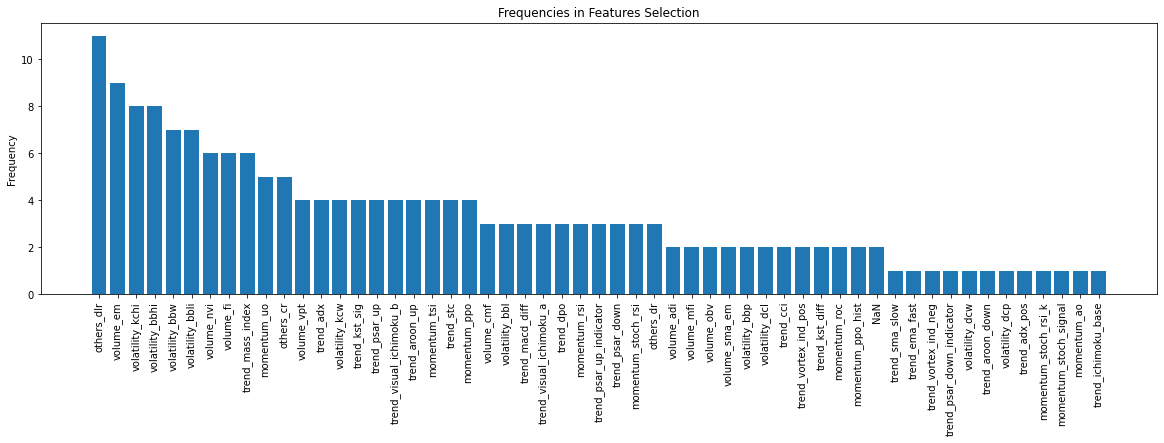

In [282]:
# Plot the dsitribution of apparition of the different features 
liste = Table_Selected_Features.values.tolist()
full_liste = []
for i in range(len(liste)):
    for j in range(len(liste[i])):
        full_liste.append(liste[i][j])
        
occurrences = collections.Counter(full_liste)
y = [count for tag, count in occurrences.most_common()]
x = [tag for tag, count in occurrences.most_common()]

f, ax = plt.subplots(figsize=(20,5))
plt.bar(x, y)
plt.title("Frequencies in Features Selection")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()


## DETAILED STEPS of the Features Selection function

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09
3,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09
4,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09


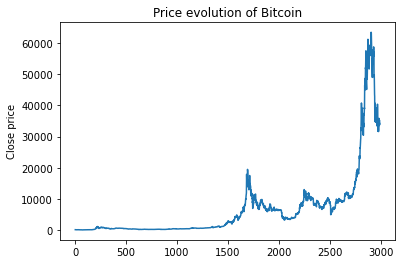

In [335]:
# load data 

Crypto = pd.read_csv("/Users/diego/OneDrive/Bureau/GitHub/ML_Finance/Crypto df/coin_Bitcoin.csv") 

# let's have a look at the data
plt.plot(Crypto["Close"])
plt.ylabel("Close price")
crypto_name = Crypto["Name"][0]
plt.title("Price evolution of " + crypto_name)
Crypto.head()

In [336]:
# Clean nan values

Crypto = ta.utils.dropna(Crypto)

# Add all technical analysis features filling nans values

Crypto = ta.add_all_ta_features(Crypto, "Open", "High", "Low", "Close", "Volume", fillna=True)

#print(Cardano.columns)

C:\Users\diego\anaconda3\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\diego\anaconda3\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


In [337]:
Crypto

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap,volume_adi,volume_obv,volume_cmf,volume_fi,volume_mfi,volume_em,volume_sma_em,volume_vpt,volume_nvi,volume_vwap,volatility_atr,volatility_bbm,volatility_bbh,volatility_bbl,volatility_bbw,volatility_bbp,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcw,volatility_kcp,volatility_kchi,volatility_kcli,volatility_dcl,volatility_dch,volatility_dcm,volatility_dcw,volatility_dcp,volatility_ui,trend_macd,trend_macd_signal,trend_macd_diff,trend_sma_fast,trend_sma_slow,trend_ema_fast,trend_ema_slow,trend_adx,trend_adx_pos,trend_adx_neg,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_ind_diff,trend_trix,trend_mass_index,trend_cci,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_conv,trend_ichimoku_base,trend_ichimoku_a,trend_ichimoku_b,trend_visual_ichimoku_a,trend_visual_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,trend_psar_up,trend_psar_down,trend_psar_up_indicator,trend_psar_down_indicator,trend_stc,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr
242,243,Bitcoin,BTC,2013-12-27 23:59:59,777.510010,713.599976,763.280029,735.070007,4.686270e+07,8.955395e+09,-1.537645e+07,4.686270e+07,-0.328117,0.000000e+00,50.000000,0.000000,0.000000,-6.091301e+06,1000.000000,742.059998,0.000000,735.070007,735.070007,735.070007,0.000000,0.000000,0.0,0.0,742.059998,805.970032,678.149963,17.225032,0.445314,0.0,0.0,713.599976,777.510010,745.554993,8.694415,0.335941,0.000000,0.000000,0.000000,0.000000,735.070007,735.070007,735.070007,735.070007,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-89.523154,1.000000,0.000000,6545.202219,-899.032621,-899.032621,0.000000,745.554993,745.554993,745.554993,745.554993,7158.248889,7044.852011,4.0,4.0,0.0,-1.000000,-1.000000,0.0,0.0,0.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.594148,33.594148,-66.405852,0.000000,735.070007,0.000000,0.000000,0.000000,0.000000,-89.903262,0.000000,0.000000
243,244,Bitcoin,BTC,2013-12-28 23:59:59,747.059998,705.349976,737.979980,727.830017,3.250580e+07,8.869919e+09,-1.284359e+07,1.435690e+07,-0.161822,-2.353417e+08,0.000000,-2482.908219,-2482.908219,-4.245126e+07,990.150611,735.788338,0.000000,731.450012,738.690002,724.210022,1.979627,0.250000,0.0,0.0,734.403330,787.213359,681.593302,14.381751,0.437765,0.0,0.0,705.349976,777.510010,741.429993,9.865340,0.311530,0.000000,-0.577549,-0.115510,-0.462039,731.450012,731.450012,733.956163,734.533712,0.000000,0.000000,0.000000,0.005063,0.010919,-0.005856,-0.001924,1.943639,-66.666667,6548.822214,-899.529854,-899.281237,-0.248617,741.429993,741.429993,741.429993,741.429993,7158.248889,7044.852011,4.0,8.0,-4.0,-1.000000,-1.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,-100.000000,21.283876,31.153036,32.373592,-68.846964,0.000000,731.817595,0.000000,-2.500653,-0.500131,-2.000522,-0.984939,-0.989821,-0.984939
244,245,Bitcoin,BTC,2013-12-29 23:59:59,748.609985,714.440002,728.049988,745.049988,1.901130e+07,9.082104e+09,2.206332e+06,3.336820e+07,0.022427,-1.549537e+08,37.199037,956.192156,-763.358031,1.296324e+05,1013.576912,735.835681,0.000000,735.983337,750.102589,721.864086,3.836840,0.821074,0.0,0.0,734.946662,781.543342,688.349982,12.680289,0.608413,0.0,0.0,705.349976,777.510010,741.429993,9.804574,0.550166,0.000000,0.350210,-0.022366,0.372576,735.983337,735.983337,735.662905,735.312695,0.000000,0.000000,0.000000,0.011550,0.015774,-0.004224,-0.000474,2.831246,13.251992,6544.288889,-898.907168,-899.156548,0.249380,741.429993,741.429993,741.429993,741.429993,7158.248889,7044.852011,12.0,8.0,4.0,-1.000000,777.510010,0.0,1.0,0.000000,71.921234,0.000000,0.000000,0.000000,-94.850634,37.978405,55.016621,39.921268,-44.983379,0.000000,738.216009,0.000000,-7.088933,-1

In [338]:
# List of our indicators 

indicators = ['volume_adi', 'volume_obv', 'volume_cmf',
       'volume_fi', 'volume_mfi', 'volume_em', 'volume_sma_em', 'volume_vpt',
       'volume_nvi', 'volume_vwap', 'volatility_atr', 'volatility_bbm',
       'volatility_bbh', 'volatility_bbl', 'volatility_bbw', 'volatility_bbp',
       'volatility_bbhi', 'volatility_bbli', 'volatility_kcc',
       'volatility_kch', 'volatility_kcl', 'volatility_kcw', 'volatility_kcp',
       'volatility_kchi', 'volatility_kcli', 'volatility_dcl',
       'volatility_dch', 'volatility_dcm', 'volatility_dcw', 'volatility_dcp',
       'volatility_ui', 'trend_macd', 'trend_macd_signal', 'trend_macd_diff',
       'trend_sma_fast', 'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
       'trend_adx', 'trend_adx_pos', 'trend_adx_neg', 'trend_vortex_ind_pos',
       'trend_vortex_ind_neg', 'trend_vortex_ind_diff', 'trend_trix',
       'trend_mass_index', 'trend_cci', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_conv',
       'trend_ichimoku_base', 'trend_ichimoku_a', 'trend_ichimoku_b',
       'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b', 'trend_aroon_up',
       'trend_aroon_down', 'trend_aroon_ind', 'trend_psar_up',
       'trend_psar_down', 'trend_psar_up_indicator',
       'trend_psar_down_indicator', 'trend_stc', 'momentum_rsi',
       'momentum_stoch_rsi', 'momentum_stoch_rsi_k', 'momentum_stoch_rsi_d',
       'momentum_tsi', 'momentum_uo', 'momentum_stoch',
       'momentum_stoch_signal', 'momentum_wr', 'momentum_ao', 'momentum_kama',
       'momentum_roc', 'momentum_ppo', 'momentum_ppo_signal',
       'momentum_ppo_hist', 'others_dr', 'others_dlr', 'others_cr']

In [339]:
# compute the returns 

Crypto["Returns"] = Crypto["Close"].pct_change()

# keep only the relevant columns, ie. the ta indicators and the returns. 

Crypto = Crypto[indicators].join(Crypto["Returns"]).iloc[1: , :] #drop the first row as return = NaN

Crypto

,volume_adi,volume_obv,volume_cmf,volume_fi,volume_mfi,volume_em,volume_sma_em,volume_vpt,volume_nvi,volume_vwap,volatility_atr,volatility_bbm,volatility_bbh,volatility_bbl,volatility_bbw,volatility_bbp,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcw,volatility_kcp,volatility_kchi,volatility_kcli,volatility_dcl,volatility_dch,volatility_dcm,volatility_dcw,volatility_dcp,volatility_ui,trend_macd,trend_macd_signal,trend_macd_diff,trend_sma_fast,trend_sma_slow,trend_ema_fast,trend_ema_slow,trend_adx,trend_adx_pos,trend_adx_neg,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_ind_diff,trend_trix,trend_mass_index,trend_cci,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_conv,trend_ichimoku_base,trend_ichimoku_a,trend_ichimoku_b,trend_visual_ichimoku_a,trend_visual_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,trend_psar_up,trend_psar_down,trend_psar_up_indicator,trend_psar_down_indicator,trend_stc,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr,Returns
243,-1.284359e+07,1.435690e+07,-0.161822,-2.353417e+08,0.000000,-2482.908219,-2482.908219,-4.245126e+07,990.150611,735.788338,0.000000,731.450012,738.690002,724.210022,1.979627,0.250000,0.0,0.0,734.403330,787.213359,681.593302,14.381751,0.437765,0.0,0.0,705.349976,777.510010,741.429993,9.865340,0.311530,0.000000,-0.577549,-0.115510,-0.462039,731.450012,731.450012,733.956163,734.533712,0.000000,0.000000,0.000000,0.005063,0.010919,-0.005856,-0.001924,1.943639,-66.666667,6548.822214,-899.529854,-899.281237,-0.248617,741.429993,741.429993,741.429993,741.429993,7158.248889,7044.852011,4.0,8.0,-4.0,-1.000000,-1.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,-100.000000,21.283876,31.153036,32.373592,-68.846964,0.000000,731.817595,0.000000,-2.500653,-0.500131,-2.000522,-0.984939,-0.989821,-0.984939,-0.009849
244,2.206332e+06,3.336820e+07,0.022427,-1.549537e+08,37.199037,956.192156,-763.358031,1.296324e+05,1013.576912,735.835681,0.000000,735.983337,750.102589,721.864086,3.836840,0.821074,0.0,0.0,734.946662,781.543342,688.349982,12.680289,0.608413,0.0,0.0,705.349976,777.510010,741.429993,9.804574,0.550166,0.000000,0.350210,-0.022366,0.372576,735.983337,735.983337,735.662905,735.312695,0.000000,0.000000,0.000000,0.011550,0.015774,-0.004224,-0.000474,2.831246,13.251992,6544.288889,-898.907168,-899.156548,0.249380,741.429993,741.429993,741.429993,741.429993,7158.248889,7044.852011,12.0,8.0,4.0,-1.000000,777.510010,0.0,1.0,0.000000,71.921234,0.000000,0.000000,0.000000,-94.850634,37.978405,55.016621,39.921268,-44.983379,0.000000,738.216009,0.000000,-7.088933,-1.817891,-5.271042,2.365933,2.338379,1.357691,0.023659
245,6.464174e+06,5.407590e+07,0.054281,-1.000401e+08,55.625599,2787.135170,420.139703,7.577494e+05,1013.576912,739.050431,0.000000,741.020004,762.325663,719.714345,5.750360,0.854601,0.0,0.0,739.790827,781.328334,698.253321,11.229527,0.696680,0.0,0.0,705.349976,777.510010,741.429993,9.737933,0.703714,0.000000,1.956971,0.373502,1.583470,741.020004,741.020004,738.811690,736.854718,0.000000,0.000000,0.000000,0.019325,0.016967,0.002359,0.006118,3.661183,115.325833,6539.252222,-898.215344,-898.921247,0.705903,741.429993,741.429993,741.429993,741.429993,7158.248889,7044.852011,16.0,8.0,8.0,-1.000000,776.248610,0.0,0.0,0.000000,81.260429,0.000000,0.000000,0.000000,-87.732937,41.516721,70.371404,52.180354,-29.628596,0.000000,746.502271,0.000000,-10.620253,-3.578364,-7.041890,1.487151,1.476201,2.865033,0.014872
246,1.510844e+07,3.317860e+07,0.107929,-9.207753e+07,42.962004,-433.779509,206.659900,2.493640e+05,1013.576912,740.822352,0.000000,743.618005,765.323734,721.912277,5.837871,0.739384,0.0,0.0,742.016663,779.728674,704.304651,10.164734,0.659012,0.0,0.0,705.349976,777.510010,741.429993,9.7

In [287]:
## look at the correlations between the features and the returns

#pd.DataFrame(np.corrcoef(Crypto, rowvar=False))

# if a coefficient is > 0.9 , drop it

#######                     #######
####### CODE GENERALIZATION #######
#######                     #######


#(so far, we did it manually, not good)



In [288]:
# split into train and test sets

#Crypto_train, Crypto_test = train_test_split(Crypto,train_size = 0.80,random_state=None, shuffle=False)

In [301]:
# standardize

sc = StandardScaler()
Z_Crypto_train = sc.fit_transform(Crypto)

In [302]:
# Lasso regression (alpha = 1.0)

from sklearn.linear_model import Lasso
regLasso1 = Lasso(fit_intercept=False,normalize=False, max_iter=1000)
#print(regLasso1)

In [303]:
# Rename for clarity 
# We use Features from t=0 to t=T-1 to predict Returns from t=1 to t=T, where T is the final observation date

X,y = pd.DataFrame(Z_Crypto_train[:-1,:-1]),pd.DataFrame(Z_Crypto_train[1:,-1:])

In [304]:
# fit

regLasso1.fit(X,y)

Lasso(fit_intercept=False)

In [305]:
# obtain coeffficients of the LASSO regression for multiple alphas

from sklearn.linear_model import lasso_path
alpha_for_path, coefs_lasso, _ = lasso_path(X,y,n_alphas=500)


C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.33702039461877575, tolerance: 0.27479068741346513
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.28939790075219207, tolerance: 0.27479068741346513
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3986533390993827, tolerance: 0.27479068741346513
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1906023759015625, tolerance: 0.27479068741346513
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1878922864016204, tolerance: 0.27479068741346513
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.185693080699366, tolerance: 0.27479068741346513
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coo

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3218481497920038, tolerance: 0.27479068741346513
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3150894570562741, tolerance: 0.27479068741346513
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3060862272732265, tolerance: 0.27479068741346513
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_co

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.347786086642827, tolerance: 0.27479068741346513
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.800521421699614, tolerance: 0.27479068741346513
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.561343052256234, tolerance: 0.27479068741346513
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_co

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48.92668603405764, tolerance: 0.27479068741346513
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 49.352941346683565, tolerance: 0.27479068741346513
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 49.73528925983783, tolerance: 0.27479068741346513
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coor

C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 91.99767192892409, tolerance: 0.27479068741346513
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 93.44326871494695, tolerance: 0.27479068741346513
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 94.42959775012173, tolerance: 0.27479068741346513
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_coord

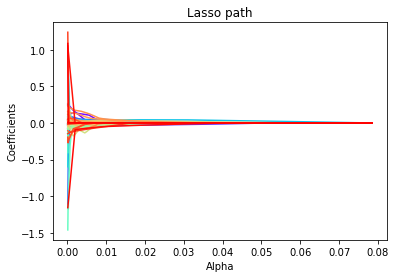

In [306]:
# graph of lasso path (coefficients given alpha)
import matplotlib.cm as cm
couleurs = cm.rainbow(np.linspace(0,1,len(indicators)))
for i in range(coefs_lasso.shape[1]):
    plt.plot(alpha_for_path,coefs_lasso[0][i,:],c=couleurs[i])
plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.title('Lasso path')
plt.show()

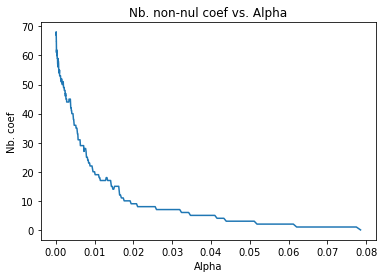

In [307]:
# number of non-nul coefficients for each alpha

nbNonZero = np.apply_along_axis(func1d=np.count_nonzero,arr=coefs_lasso[0],axis=0)
alphas_nnz_df = pd.DataFrame({'alpha':alpha_for_path,'Nb non-zero coefs':nbNonZero})

plt.plot(alpha_for_path,nbNonZero)
plt.xlabel('Alpha')
plt.ylabel('Nb. coef') 
plt.title('Nb. non-nul coef vs. Alpha') 
plt.show()

In [308]:
# get the alpha for which we get 8 selected features (and its index)
# If no such alpha exists, choose an alpha for which we get 7 selected features, etc...

alphas_to_get_8_features = alphas_nnz_df.loc[alphas_nnz_df['Nb non-zero coefs'] == 8 ]
higher_alpha_to_get_8_features = alphas_to_get_8_features.max()[0]
while np.isnan(higher_alpha_to_get_8_features) == True :
    alphas_to_get_8_features = alphas_nnz_df.loc[alphas_nnz_df['Nb non-zero coefs'] == 7 ]
    higher_alpha_to_get_8_features = alphas_to_get_8_features.max()[0]
index_higher_alpha_to_get_8_features = list(alpha_for_path).index(higher_alpha_to_get_8_features)  
#index_higher_alpha_to_get_8_features

In [309]:
# get the 8 selected features coressponding 

coefs_at_higher_alpha_to_get_8_features = coefs_lasso[0][:,index_higher_alpha_to_get_8_features]
index_coefs_at_higher_alpha_to_get_8_features = coefs_at_higher_alpha_to_get_8_features.nonzero()[0]
coefs_lasso[0][:,[index_higher_alpha_to_get_8_features,2]]
selected_features = [indicators[i] for i in index_coefs_at_higher_alpha_to_get_8_features]
selected_features

['volume_em',
 'volatility_bbw',
 'volatility_kchi',
 'trend_dpo',
 'trend_aroon_up',
 'trend_psar_up_indicator',
 'momentum_stoch_rsi',
 'others_dlr']

# Long-Short term memory


In [316]:
y = Crypto[['Returns']]
X = Crypto[Table_Selected_Features['Bitcoin']]


In [340]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

"""
### Turn each signal into a labeled dataset
"""
window_size = 30   # num. days per training sample
batch_size = 128   # num. of samples per epoch
buffer_size = 1000 # num of samples in memory for random selection
split_time = 1400  # where to split the data for training/validation


def window_dataset(series, window_size, batch_size, shuffle_buffer):
    """Funtion to turn time series data into set of sequences 
    where the last value is the intended output of our model"""
    ser = tf.expand_dims(series, axis=-1)
    data = tf.data.Dataset.from_tensor_slices(series)
    data = data.window(window_size + 1, shift=1, drop_remainder=True)
    data = data.flat_map(lambda w: w.batch(window_size + 1))
    data = data.shuffle(shuffle_buffer)
    data = data.map(lambda w: (w[:-1], w[1:]))
    return data.batch(batch_size).prefetch(1)


x_train = X[:split_time,:]
x_test = X[split_time:,:]

print(f"Training data shape: {x_train.shape}")
print(f"Validation data shape: {x_test.shape}")

train_set = window_dataset(x_train,window_size,batch_size,buffer_size)

ImportError: Traceback (most recent call last):
  File "C:\Users\diego\anaconda3\lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 64, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: DLL load failed while importing _pywrap_tensorflow_internal: Le module spécifié est introuvable.


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/errors

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

In [346]:
$ source activate tensorflow_p36

SyntaxError: invalid syntax (<ipython-input-346-bb134744341d>, line 1)

In [279]:
from sklearn.svm import SVC
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


In [280]:
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(X)
X_normalized_min_max = min_max_scaler.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_normalized_min_max, y, test_size= 0.15, shuffle=False)
model = LinearRegression()

# Fit model
model.fit(X_train,y_train)

# Predict CO2 values
preds = model.predict(X_test)

In [281]:
#def compute_Pi(X,y, n_splits=1000):
"""
    Computes the 95% CI intervals based on TimeSeries cross validation bootstrapping.
    Returns an array of shape (2, nbr samples).
    
    Parameters
    ==========
    X: (numpy.ndarray)
        Features array of the data of the whole data 
    y: (numpy.ndarray)
        Daily returns of the wole data
    
        
    Returns
    ==========
    Pi: (numpy.ndarray)
        Arrays of tuples with the 2.5th and the 97.5th percentile
        
"""
tscv = TimeSeriesSplit(n_splits=10)
results = np.empty(len(y))

# Bootstrap over TimeSeries splits
for train_index, test_index in tscv.split(X) :
    # Get sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    # Train model
    model_tmp = LinearRegression().fit(X_train, y_train)
    # Compute predictions
    preds = model_tmp.predict(X_test)
    print(preds)
    # Store predictions
    #results = np.c_[results, preds]

# Get 95% PI of predictions
#Pi = np.percentile(results, [2.5, 97.5], axis=1)
#return Pi

# Return the predictions
Pi = preds
#return Pi
#
#PI = compute_Pi(X,y)
#

[[-8.91894000e-04]
 [ 3.45539123e-03]
 [ 2.17265089e-03]
 [-2.82175310e-03]
 [-1.53496654e-02]
 [-1.79756323e-02]
 [-3.97560712e-02]
 [-4.20128554e-02]
 [-6.14361875e-03]
 [-1.09318394e-02]
 [-6.93959446e-03]
 [ 2.17726532e-02]
 [ 7.97633965e-03]
 [-4.57816652e-03]
 [-6.35573605e-03]
 [-5.08318363e-03]
 [-2.03842659e-02]
 [-9.89971730e-03]
 [-4.37147113e-04]
 [-1.38046936e-03]
 [-8.34309280e-03]
 [-1.69786737e-02]
 [-3.13485733e-02]
 [-3.04029002e-02]
 [-5.65298361e-03]
 [-3.29075882e-03]
 [ 1.00852987e-02]
 [ 1.65680199e-02]
 [ 6.46345059e-03]
 [ 5.66191615e-03]
 [ 1.47924417e-02]
 [ 1.90323410e-02]
 [ 1.69047643e-02]
 [ 4.04365912e-03]
 [-2.14423037e-03]
 [ 2.27365296e-03]
 [ 1.55554633e-02]
 [ 9.92439948e-03]
 [-1.25736799e-04]
 [ 5.15689276e-03]
 [-1.25939314e-03]
 [-2.73268712e-02]
 [-2.10821785e-02]
 [-2.02721679e-02]
 [-9.92002916e-03]
 [-9.30886738e-03]
 [-5.50443085e-03]
 [-2.51970198e-02]
 [-1.02396800e-02]
 [-1.19760256e-02]
 [-2.58363063e-02]
 [-1.89268103e-02]
 [-1.0149299

In [263]:
y_test

,Returns
2742,0.017309
2743,-0.003184
2744,-0.013585
2745,0.029505
2746,0.013147
...,...
2986,0.009679
2987,0.022760
2988,0.017861
2989,-0.043692


In [245]:
#create a DF for the PI array
PI =pd.DataFrame(PI)
PI

,0
0,-0.022199
1,0.011300


In [204]:
#create an array with the days to plot the graphs
z = np.arange(0,2748,1)
z = np.vstack(z)
z=pd.DataFrame(z)
z


,0
0,0
1,1
2,2
3,3
4,4
...,...
2743,2743
2744,2744
2745,2745
2746,2746


In [205]:
y.index -=243
y = pd.DataFrame(y)


ValueError: x and y must have same first dimension, but have shapes (2748, 1) and (2, 2)

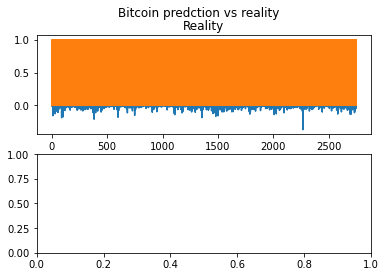

In [206]:
# plot our predictions vs the truth
fig, (ax1, ax2) = plt.subplots(2,1)
fig.suptitle('Bitcoin predction vs reality')
ax1.plot(z, y)
ax1.title.set_text('Reality')
ax2.plot(z,PI)
ax2.title.set_text('Prediction')
fig.tight_layout(pad=2.0)

In [198]:
#create a new column in the y df which takes 1 if the return is prositive, and 0 otherwise
y['positive?'] = np.where(y['Returns']>=0, 1, 0)
y

,Returns,positive?
0,-0.009849,0
1,0.023659,1
2,0.014872,1
3,-0.002804,0
4,0.023063,1
...,...,...
2743,0.009679,1
2744,0.022760,1
2745,0.017861,1
2746,-0.043692,0


In [199]:
#create a new column in the PI df which takes 1 if the return is prositive, and 0 otherwise
PI['positive?'] = np.where(PI[0]>=0, 1, 0)
PI

,0,positive?
0,-0.025292,0
1,-0.004941,0
2,0.006617,1
3,-0.007734,0
4,0.006006,1
...,...,...
2743,0.002298,1
2744,0.035746,1
2745,0.045044,1
2746,-0.022199,0


In [163]:
#Compare the two columns, and each time they ended up taking the same value, we return 1, and 0 otherwise
df = np.where(PI['positive?']==y['positive?'],1,0)
np.sum(df)

1861

In [ ]:
## Plot Pi evolution
def plot_Pi_evolution(df_actual_pi, preds_array, Pi_array, title="") : 
    """
    Plot the actual profits measurements against the predictions with 95% CIs.
    
    Parameters
    ===========
    df_actual_pi: (pd.DataFrame) DataFrame containing the actual Profits measurements in a "Pi" column.
    preds_array: (np.array) Array containing the Profits predictions. Must be of same length as df_actual_pi.
    pi_array: (np.Array) Array containing the confidence intervals. Must be of shape (2, length of df_actual_pi).
    """
    # Isolate PI measurements
    df_plot_Pi_drifty = df_actual_pi.copy()
    #display(df_plot_PI_drifty.head(1))

    # Isolate predictions
    df_plot_Pi_preds = df_plot_Pi_drifty.copy()
    df_plot_Pi_preds["Returns"] = preds
    # Add PI
    df_plot_Pi_preds["Pi"] = Pi_array[1,:] - Pi_array[0,:]
    #display(df_plot_PI_preds.head(1))
    df_plot_Pi_compare = pd.concat([df_plot_Pi_drifty.assign(origin="Real"), 
                                     df_plot_Pi_preds.assign(origin="Predicted")])\
                            .sort_index()\
                            .fillna(0)\
                            .reset_index()
    

    #display(df_plot_Pi_compare.head(4))

    # Plot 
    fig = px.line(df_plot_Pi_compare,
                  x="timestamp",
                  y="Pi",
                  color="origin",
                  error_y='Pi',
                  category_orders={"origin":["Predicted", "Real"]},
                  title=title,
                  )
    fig.update_layout(margin=dict(l=50,r=50,b=50,t=50))
    fig.show()
        
plot_Pi_evolution(Crypto['Returns'], preds, Pi, title="Profits estimated vs real")

In [ ]:
# Get a nicer visualization with matplotlib for Confidence Intervals

def plot_Pi_evolution_nice(df, preds, Pi, title):
    


    fig, ax = plt.subplots(figsize=(18, 8))

    # Plotting of lines
    ax.plot(dates, preds, label='Pi Predictions')
    ax.plot(dates, Pi[0], 'b', alpha=0.3)
    ax.plot(dates, Pi[1], 'b', alpha=0.3)
    ax.plot(dates, y, 'r', label='Pi Measurements')
    ax.fill_between(dates, Pi[0], Pi[1], alpha=.3)

    ax.legend()
    ax.set_title('Pi Measurements vs Pi Predictions with 95% Confidence Interval', fontsize=18)
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Pi')
    
    fig.suptitle(title, fontsize=22)
    fig.show()
    
plot_Pi_evolution_nice(df, preds, Pi, title='Returns predictions')